
# Respuesta Examen Primer Parcial Aprendizaje Automático Noviembre 2021

* Construiremos un modelo que pr**edice la eficiencia de combustible de vehículos** entre 1970 y 1980 a partir de del conjunto de datos Auto MPG124.

* **PASO 1**: **Definir el problema** y plantearse si tenemos los datos adecuados para atacarlo ¿Qué intentamos predecir? **MPG de una serie de coches (valor continuo)** ¿Cuáles serán los datos de entrada?:
  - **Millas por galón** (Miles per Gallon) (mpg):variable continua 
  - **Cilindros** (cylinders) : variable discreta de valores múltiples
  - **Desplazamiento** (displacement) : variable continua
  - **Potencia** (horsepower) : variable continua
  - **Peso** (weight) : variable continua
  - **Aceleración** (acceleration) : variable continua
  - **Año del modelo** (model year) : variable discreta de valores múltiples
  - **Origen** (origin) : variable categórica 
* ¿Qué tipo de problema estamos intentando solucionar? Es claramente una **REGRESIÓN**
  - Consideraremos como entrada al modelo los datos **cylinders**, **displacement**, **horsepower**, **weight**, **acceleration**, **model year** y **origin**. 
- Consideramos como salida: **Miles per Gallon** (mpg). 

Estamos ante una **hipótesis de trabajo que parece bastante plausible**, es decir, con esta información de un coche podremos estimar cuál será su consumo. Es una típica tarea de regresión

### Inicialización

Primero importamos todos los paquetes Python 
que se usarán en el código o pseudocódigo de este examen

In [11]:
%tensorflow_version 2.x
import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


2.7.0


### Descarga datos Auto MPG

Descargamos el dataset Auto MPG. En este ejercício toda la información se encuentra en un único fichero llamado `auto-mpg.data`. En el examen, obviamente, esto no era necesario. Damos por hecho que lo tenemos cargado ya en las variables correspondientes

In [12]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

* El siguiente paso es importar los datos usando la librería **Pandas** para manipulación y análisis de datos. 
* Pandas ofrece estructuras de datos y operaciones para manipular tablas numéricas. Especialmente útil la clase `DataFrame`

In [13]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year', 'Origin'] 

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

* Una práctica interesante es echarle un vistazo rápido a la estructura de datos. 
* Podemos visualizar las cinco últimas filas con el método `tail()` que nos ofrece Pandas

In [14]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [15]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


* Podemos ver que los valores de las diferentes columnas son los esperados y podemos comprobar que disponemos de **398 muestras** (de la 0 a la 397). 

**TRATAMIENTO DE VALORES VACÍOS**
* También es interesante comprobar en esta etapa **si falta algún valor** para garantizar que nuestros datos son correctos. Para ello, podemos usar el método `insa()` que nos ofrece Pandas para detectar si faltan elementos. 
* **Qué hacer con los datos perdidos**: Es muy habitual, en los problemas del mundo real, que falten algunos valores de los datos de muestra. Esto puede ser debido a errores de recopilación de datos, a errores de transformación de datos, etc. Los campos vacíos se representan típicamente con los indicadores ``NaN`` o ``Null``. **El problema es que en redes neuronales no podemos dejar estos valores faltantes**, por lo que **los tenemos que 
tratar antes de alimentar nuestro modelo con datos**. 
* En el examen, ya os decía que había valores que faltaban y quería que me dijerais que vais a hacer con ellos. A priori, cualquier respuesta bien argumentada era válida: 
  - **Borrarlos**: eliminando las características (columnas) o muestras (filas) con campos vacíos, destacando que no sería la mejor opción porque hay muy pocos valores en el DataSet
  - **Mantenerlo con valor 0**, ya que no es un valor representativo en los datos (no existen coches con 0 caballos de vapor, con lo que el sistema aprendería que son valores nulos)
  - Meterle la **media de los valores de los CV del resto de datos** con valor. La librería `ScikitLearn` nos ayuda a estimar los campos vacíos con algún estimador

In [16]:
print(dataset.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


* Para mantener este ejemplo simple, optamos por la primera opción y, simplemente, borramos las filas usando el método ``dropna()`` que nos proporciona Pandas.
* Este es un paso delicado en los casos reales y requiere una decisión más pensada, puesto que simplemente eliminando corremos el riesgo de borrar información relevante —podemos estar borrando demasiadas muestras, o incluso podemos estar modificando la distribución de los datos de entrada—.

In [17]:
dataset = dataset.dropna()

**MANEJO DE DATOS CATEGÓRICOS** 
* La columna de datos ``Origin`` no es numérica, sino categórica, es decir, el 1 significa «USA», el 2 «Europa» y el 3 «Japan». Cuando sucede esto, se usa habitualmente la técnica de **codificación one-hot**
* Consiste en crear una característica «ficticia» para cada valor único en la columna de características. Asigna a los datos de entrada su propio vector y les da un valor de 1 o 0. 
* Para ello, en nuestro caso de datos, usaremos el método ``pop()`` que proporciona Pandas para extraer de los datos la columna Origin, y la sustituiremos por tres nuevas columnas:

In [18]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

Podemos volver a echarle un vistazo rápido a la estructura de datos con el método ``tail()``; vemos que se han creado las tres nuevas columnas que sustituyen a la columna ``Origin``:

In [19]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Esto ya se os da hecho en el Examen

## Separar los datos para entrenar y evaluar

En los ejemplos vistos en clase, los datos ya se encontraban divididos en cuatro arrays NumPy, al igual que se han dado en el examen:
* Datos de entrenamiento (training) y sus etiquetas respectivas: 
  - ``train_data``
  - ``train_labels``
* Datos de prueba (test) y sus etiquetas respectivas:
  - ``test_data``
  - ``test_labels`` 

Aquí os cuento como se han partido para el examen, pero debeis tener en cuenta y hablar sobre ello que para la configuración y evaluación de un modelo en Machine Learning, habitualmente se dividen los datos disponibles en dos conjuntos: 
* Datos de entrenamiento (training)
* Datos de prueba (test). 

A su vez, **una parte de los datos de entrenamiento (training) se reservan como datos de validación(validation)**. 
Los datos de entrenamiento que nos quedan después de sacar los de validación y prueba son los que se usan para que el algoritmo de aprendizaje calcule los parámetros del modelo, mientras que los de **validación se usan para afinar los hiperparámetros**. 

Con las métricas —como con la precisión (**accuracy**)— que se pueden obtener de este conjunto de datos de validación nos guiamos para decidir cómo ajustar los hiperparámetros del algoritmo antes de repetir el proceso de entrena- 
miento. 

Es importante notar en el examen que **cuando nos esforzamos para mejorar el algoritmo ajustando los hiperparámetros gracias al comportamiento del modelo con los datos de validación**, estamos **inadvertidamente incidiendo en el modelo, que 
puede sesgar los resultados a favor del conjunto de validación**. De aquí la importancia de disponer de un conjunto de datos de prueba **reservados para una prueba final**, con **datos que el modelo no ha visto nunca anteriormente** durante la etapa de 
entrenamiento (ni como datos de entrenamiento ni como datos de validación).

Esto permite obtener una medida de comportamiento del algoritmo más objetiva y **evaluar si nuestro modelo generaliza correctamente**. 

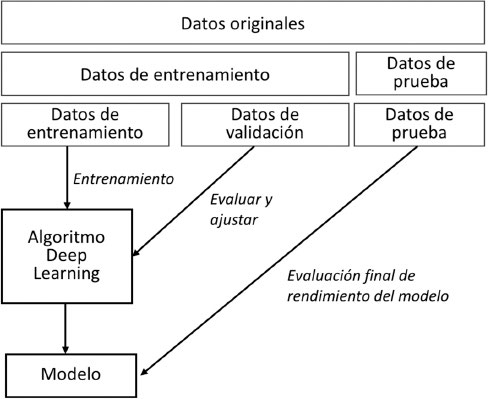



Esta es la estrategia de evaluación más habitual. Pero hay otras e**strategias de repartir los datos para validar** los modelos **cuando tenemos escasez de datos**, como por ejemplo la **validación cruzada** (cross-validation) que, básicamente, **divide los datos en K particiones del mismo tamaño** y para cada partición ``i`` el modelo es entrenado con las restantes ``K-1`` particiones, y evaluado en la propia partición ``i``. 

En nuestro ejemplo podemos repartir los datos mediante el método ``sample()`` que nos proporciona Pandas, indicando con el argumento ``frac`` inicializado a 0.8 que **queremos usar el 80 % de los datos para entrenamiento**, y que los almacenamos en ``train_data``:

In [37]:
train_data = dataset.sample(frac=0.8,random_state=0)
# El resto de datos los almacenamos en test_data:
test_data = dataset.drop(train_data.index)

También debemos **separar la columna de datos que contiene los valores que queremos predecir (MPG)**:

In [21]:
train_labels = train_data.pop('MPG')
test_labels = test_data.pop('MPG')

**NORMALIZAR LOS DATOS DE ENTRADA** 
Como venimos estudiando, es una buena práctica normalizar los datos para ser consumidos por las redes neuronales: 
* Sus valores generalmente deben **escalarse a valores pequeños**, en el rango ``[-1, 1]`` o ``[0, 1]``. 
* Si **diferentes características** de los valores de entrada **presentan valores en diferentes rangos** (datos heterogéneos), es **conveniente normalizar los datos**. 

Podemos inspeccionar los datos de entrada mediante el método ``describe()`` que ofrece el paquete Pandas para ver medianas y desviaciones.

In [38]:
train_stats = train_data.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


* Mirando el resultado podemos observar lo diferente de los rangos de cada característica. **Procede normalizar**. 
* Aunque el modelo **podría converger sin normalización** de características, se ha demostrado que **no hacerlo dificulta el entrenamiento**, y puede hacer que el **modelo resultante dependa de la elección de las unidades** utilizadas en la entrada. 
* Importante **normalizar** de la misma manera el **conjunto de datos de prueba**, así como los **datos que posteriormente use el modelo durante la etapa de inferencia**. 

In [23]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

La función `norm` reescala las características en un rango [0,1] (normalización) y centra las columnas de características con respecto a una media 0 con desviación estándar 1 (estandarización), de forma que las **columnas de características tengan los mismos parámetros que una distribución normal estándar** (media cero y varianza unidad).

Vemos como los datos se han estandarizado adecuadamente:

In [39]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


## Desarrollar el modelo

Ahora tenemos que desarrollar un modelo que cumpla 
con nuestras expectativas.Vamos a decidir por qué tipo de arquitectura nos decantamos, y el valor de los hiperparámetros.

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model():  
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=[len(train_data.keys())]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [26]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [27]:
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

## Entrenamiento del modelo

In [28]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

## Evaluación el modelo

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.410542,0.919082,2.410542,9.159993,2.388901,9.159993,995
996,2.322382,0.909231,2.322382,9.689959,2.478858,9.689959,996
997,2.295067,0.872485,2.295067,8.660074,2.273801,8.660074,997
998,2.179206,0.907440,2.179206,8.735657,2.301576,8.735657,998
999,2.129220,0.864527,2.129220,9.161232,2.351543,9.161232,999


In [30]:
def plot_history(history):     
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mse'],'b',
           label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

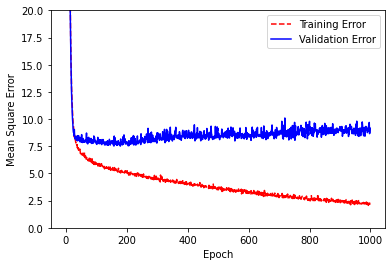

In [31]:
plot_history(history)

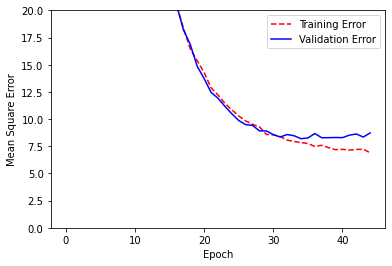

In [32]:
model = build_model()
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop] )

plot_history(history)


In [33]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} MPG".format(mse))

3/3 [==============================] - 0s 6ms/step - loss: 6.8176 - mae: 2.0713 - mse: 6.8176
Testing set Mean Abs Error:  6.82 MPG
Testing set Mean Sqr Error:  2.07 MPG


Evaluación del entrenamiento con MAE

In [34]:
model = build_model()
model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop] )




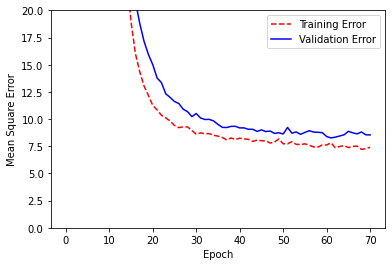

In [35]:
plot_history(history)

In [36]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} MPG".format(mse))

3/3 [==============================] - 0s 6ms/step - loss: 1.6897 - mae: 1.6897 - mse: 5.7170
Testing set Mean Abs Error:  5.72 MPG
Testing set Mean Sqr Error:  1.69 MPG
